In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit


import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [2]:
# Helper Functions

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

######### Taken from sklearn #######
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=[10,10])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot

def get_split(features, labels):
    
    # The train set will have equal amounts of each target class
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(features, labels):
        X_train = features[train_index]
        y_train = labels.iloc[train_index]
        X_test = features[test_index]
        y_test = labels.iloc[test_index]
        
        yield X_train, y_train, X_test, y_test

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    
    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.show()
    

def remove_label(features, labels, label="MCI"):
    labels = pd.Series(fused_labels)
    non_samples = labels != label

    stripped_features = features[non_samples]
    stripped_labels = labels[non_samples]

    return stripped_features, stripped_labels


In [3]:
# FLAGS

DROP_MCI = True # Whether to drop MCI samples or not

### Getting data from csv

In [4]:
filename = "ICV_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 300 entries, PTID to DX_bl
dtypes: float64(149), int64(148), object(3)
memory usage: 335.2+ KB
None


,PTID,scandate,ICV,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,307244.6,936,1.984,1158,2.107,993,2.306,1226,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,303135.8,855,2.160,1291,2.287,1137,1.961,1451,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,234729.1,849,2.122,909,2.272,788,2.430,717,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,278496.2,762,2.237,969,2.141,1153,2.130,1156,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,221848.6,752,2.073,960,2.521,873,2.374,810,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


In [5]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate", "ICV",label_col])
raw_labels = raw_data[label_col].copy()
ICVs = raw_data["ICV"].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [6]:
# Getting all the columns related to surface area
thickness_features = [x for x in features.columns if "SA" in x ]

# Removing SA to reduce feature dimensions
raw_features = features.drop(columns=thickness_features)

raw_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 148 entries, G_and_S_frontomargin_TH_lh to S_temporal_transverse_TH_rh
dtypes: float64(148)
memory usage: 165.4 KB


> ### TODO: Compare LRP with and w/o ICV

In [7]:
# # Normalize by ICV
# features_icv_normed = raw_features.div(np.power(ICVs, 1/3), axis = "rows")
# features_icv_normed.head()

## Using SMOTE

> Generates interpolated samples to balance training data 

In [8]:
def balance_data(X,y):
    sm = SMOTE(random_state=42)
    
    features, labels = sm.fit_resample(X, y)
    
    print("Original: ", X.shape)
    print("After Data Augmentation: ", features.shape)
    
    return features, labels

## Fusing all the columns

In [9]:
# Mapping to convert labels
fuse_maps = {"SMC": "CN", "EMCI":"MCI", "LMCI":"MCI"}

# Lambda fucntion to be used with Map func
fuse = lambda x: fuse_maps[x] if x in fuse_maps else x
dist = lambda x: pd.Series(x).value_counts()/len(x)

fused_labels = pd.Series(list(map(fuse, raw_labels)))

print("Sample Size:", len(fused_labels))
print("Original:\n", dist(raw_labels))
print()
print("Fused:\n", dist(fused_labels))

Sample Size: 143
Original:
 EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

Fused:
 MCI    0.468531
CN     0.349650
AD     0.181818
dtype: float64


## Getting rid of MCI samples
> Only learning CN vs AD

In [10]:
features, labels = remove_label(raw_features, fused_labels) if DROP_MCI else (raw_features, fused_labels)
print("Sample Size:", len(labels))
# print(labels)
dist(labels)

Sample Size: 76


CN    0.657895
AD    0.342105
dtype: float64

In [11]:
# labels.reshape(-1,1)

### Get 1 Hot Vector representation of the *fused* categorical labels

In [20]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder(categories="auto", sparse=False)
hot_encoder.fit(labels.values.reshape(-1,1)) # Since the function expects an array of "features" per sample

print("Categories:", hot_encoder.categories_)
hot_encoder.transform(labels[:5].values.reshape(-1,1))


Categories: [array(['AD', 'CN'], dtype=object)]


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

In [23]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator
X_train, y_train, X_test, y_test = list(get_split(features, labels))[0]
print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)
# y_train

Train Size: (60, 148)
Test Size: (16,)


90     CN
124    AD
64     CN
55     CN
28     CN
99     AD
118    CN
72     AD
111    CN
121    CN
25     CN
52     CN
45     CN
127    AD
51     CN
101    AD
91     AD
18     CN
125    CN
2      CN
136    CN
116    CN
43     AD
85     AD
92     CN
40     CN
7      AD
131    CN
103    AD
104    AD
34     AD
29     CN
27     CN
138    CN
68     CN
135    CN
117    AD
93     AD
142    CN
71     AD
15     CN
33     CN
126    CN
86     CN
139    CN
65     CN
56     CN
115    AD
123    CN
112    AD
108    AD
97     CN
80     CN
59     CN
9      AD
36     AD
5      CN
30     CN
35     AD
140    CN
dtype: object

### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [15]:
from keras import optimizers
from keras import regularizers

def exp_decay(epoch):
    initial_lr = 0.01
    decay_steps = 10
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
    print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_labels=3):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 150, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 100, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
    nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=exp_decay(0),momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=nadam,
                  metrics=['accuracy'])
    
    return dnn

num_features = X_train.shape[1]
num_labels = len(hot_encoder.categories_[0])
dnn = build_dnn(num_features, num_labels)
dnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
New Learning Rate: 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               22350     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_______________________________________________________________

In [16]:
def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, plot=True):
    
    X_train,y_train = balance_data(X,y) # Both are np arrays now
    
    y_train = hot_encoder.transform(y_train.reshape(-1,1))
    y_test = hot_encoder.transform(y_test.values.reshape(-1,1))
    
    lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(X_test, y_test),
                       callbacks=callback_list)
    
    if plot: plot_history(history)
    
    return history
    

New Learning Rate: 0.01
Original:  (60, 148)
After Data Augmentation:  (78, 148)
Instructions for updating:
Use tf.cast instead.
Train on 78 samples, validate on 16 samples
Epoch 1/30
78/78 [==============================] - 1s 7ms/step - loss: 11.7041 - acc: 0.5256 - val_loss: 10.5869 - val_acc: 0.6875
Epoch 2/30
78/78 [==============================] - 0s 210us/step - loss: 11.4318 - acc: 0.5513 - val_loss: 10.4890 - val_acc: 0.8750
Epoch 3/30
78/78 [==============================] - 0s 203us/step - loss: 10.9928 - acc: 0.6923 - val_loss: 10.3288 - val_acc: 0.8750
Epoch 4/30
78/78 [==============================] - 0s 206us/step - loss: 10.4777 - acc: 0.7692 - val_loss: 10.1904 - val_acc: 0.8750
Epoch 5/30
78/78 [==============================] - 0s 195us/step - loss: 10.1737 - acc: 0.7949 - val_loss: 10.0369 - val_acc: 0.8750
Epoch 6/30
78/78 [==============================] - 0s 214us/step - loss: 9.9949 - acc: 0.8077 - val_loss: 9.9693 - val_acc: 0.8750
Epoch 7/30
78/78 [=========

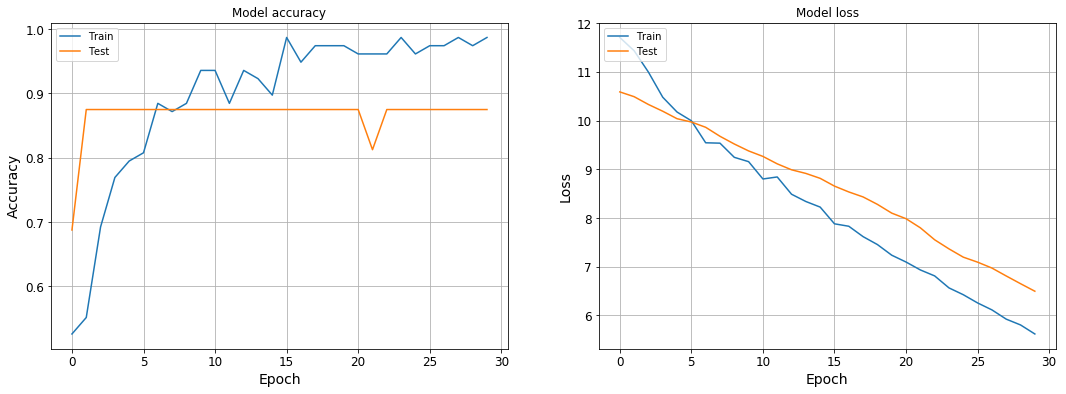

In [17]:
dnn = build_dnn(num_features, num_labels)
history = train_model(dnn, X_train, y_train, X_test, y_test, epochs=30, batch_size=10)

> AD vs CN

loss: 3.4295 - acc: 0.8846 - val_loss: 3.9303 - val_acc: 0.8125 - w/ ICV
val_acc = 0.875 -w/o ICV

### Calculating a confusion matrix

Confusion matrix, without normalization
[[5 0]
 [2 9]]


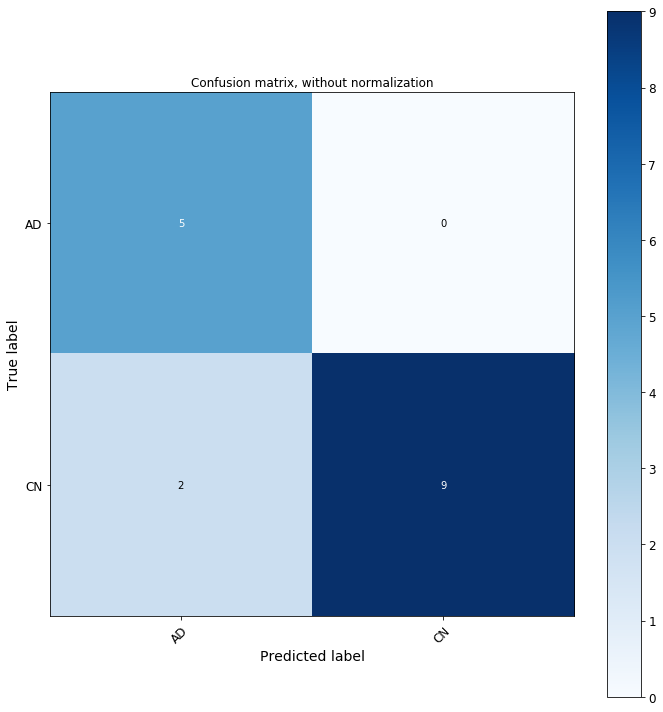

In [18]:
y_pred_probs = dnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(hot_encoder.transform(y_test.values.reshape(-1,1)), axis=1)
plot_confusion_matrix(y_true, y_pred, classes=hot_encoder.categories_[0])

In [19]:
hot_encoder.categories_[0]

array(['AD', 'CN'], dtype=object)

In [48]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

NameError: name 'labels_1hot' is not defined

In [82]:
features.shape

(76, 148)

## Using K=10 Fold Cross Validation

In [49]:
# def getKF(X,y, n_splits=10):
#     from sklearn.model_selection import KFold
#     kf = KFold(n_splits=n_splits) #Default = 10

#     for train_index, test_index in kf.split(X):
#         X_train = X[train_index]
#         y_train = y.iloc[train_index]
#         X_test = X[test_index]
#         y_test = y.iloc[test_index]
        
#         yield X_train, y_train, X_test, y_test, test_index

# histories = []
# testing_indxs =[]
# zoo = []
# for X_train, y_train, X_test, y_test, test_index in getKF(features, labels):
#     dnn = build_dnn(num_features, num_labels)
#     history = train_model(dnn,X_train, y_train, X_test, y_test)
#     histories.append(history)
#     testing_indxs.append(test_index)
#     zoo.append(dnn)
#     print(history.history["acc"][-1], history.history["val_acc"][-1])

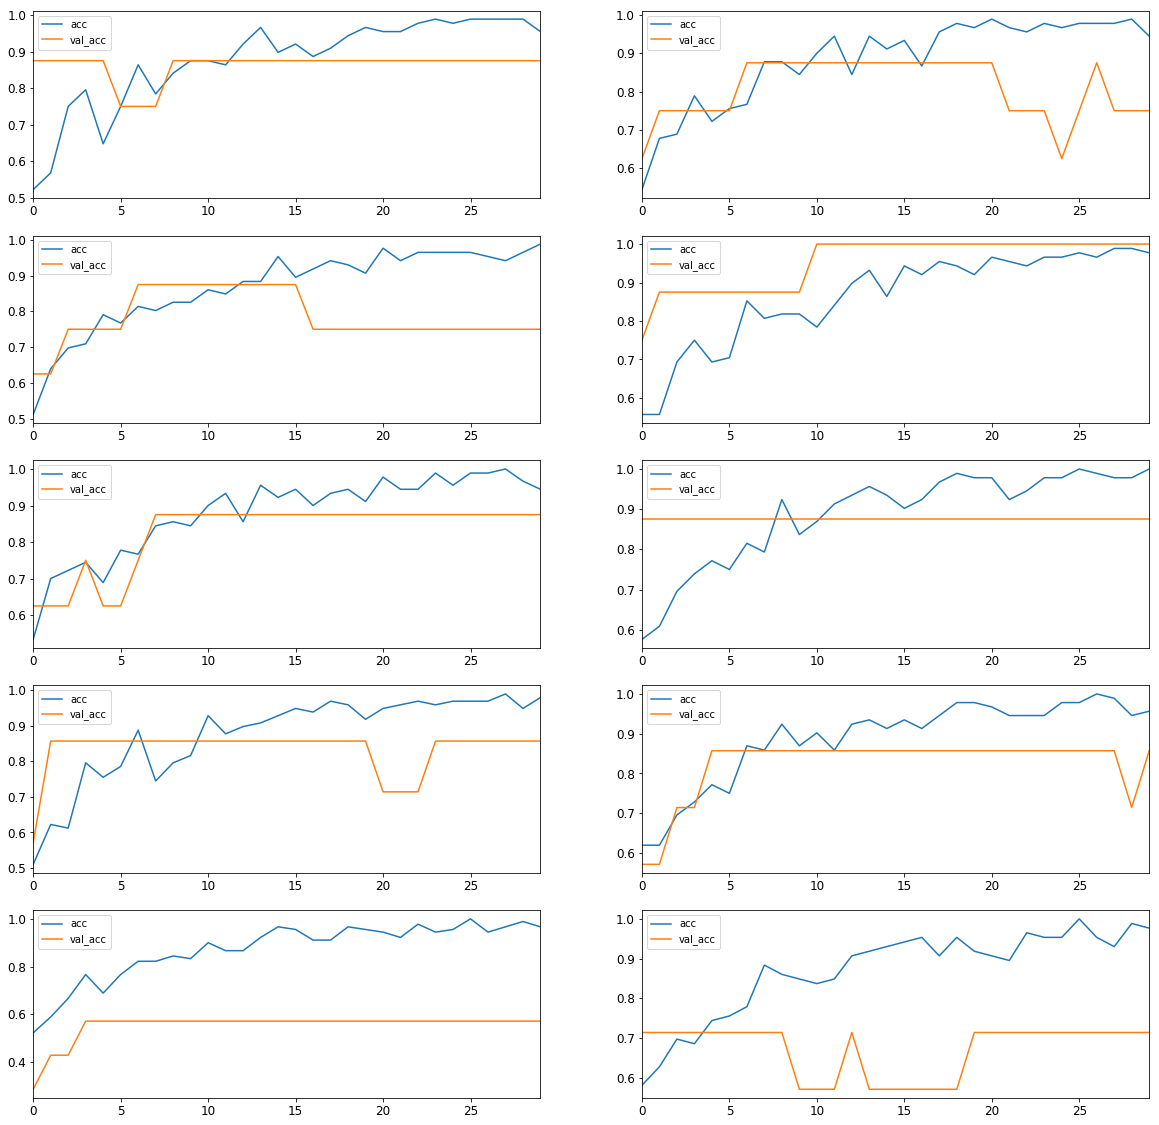

In [92]:
fig, axs = plt.subplots(len(histories)//2,2, figsize=(20,20))
axs=axs.flatten()
dfs = []

for i,history in enumerate(histories):
    df = pd.DataFrame(history.history)
    dfs.append(df)
    df[["acc","val_acc"]].plot(ax=axs[i])

Average: 0.8125000059604645


[0.875,
 0.75,
 0.75,
 1.0,
 0.875,
 0.875,
 0.8571428656578064,
 0.8571428656578064,
 0.5714285969734192,
 0.7142857313156128]

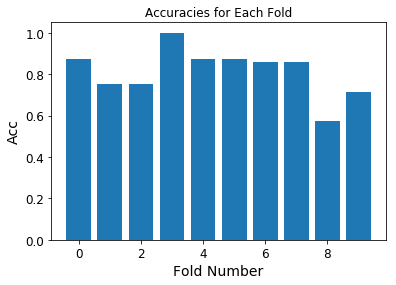

In [93]:
val_accs = [df["val_acc"].iloc[-1] for df in dfs]
print("Average:",np.mean(val_accs))
plt.bar(x=range(10),height=val_accs)
# plt.scatter(x=range(10), y=np.mean(val_accs))
plt.xlabel("Fold Number")
plt.ylabel("Acc")
plt.title("Accuracies for Each Fold")
val_accs

In [44]:
testing_indxs

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]

# Evaluating on non SMOTE Samples

In [41]:
# def get_correct_predictions(model,X,y):

model = dnn

samples = features

# hot_enc = OneHotEncoder(categories="auto", sparse=False)
sample_labels = hot_encoder.transform([[label] for label in labels])
print("Categories:", hot_encoder.categories_)

predictions = model.predict(samples)
preds = np.array([np.argmax(x) for x in predictions])
true_labels = np.array([np.argmax(x) for x in sample_labels])
correct = preds == true_labels

AD_Sample = true_labels == 0

correct_preds = preds[correct]
correct_preds.shape

Categories: [array(['AD', 'CN'], dtype=object)]


(74,)

In [38]:
loss_and_metrics = model.evaluate(samples[correct], sample_labels[correct])
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

74/74 [==============================] - 0s 51us/step
Scores on test set: loss=5.502 accuracy=1.0000


# LRP

In [72]:
import innvestigate
import innvestigate.utils as iutils


def perform_analysis(model, analyzer, data, labels):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
#     header = "{:^30} {} {}".format("Relevances","Pred", "Actual")
#     print(header)
    
#     for rel,pred,actual in zip(analysis,prediction, labels):
# #         print(np.argmax(pred), actual)
#         result = "{} {:d} {:d}".format(np.around(rel,4), np.argmax(pred), np.argmax(actual))
#         print(result)
    df_anal = pd.DataFrame(analysis)
#     print()
#     print(df_anal.describe())
    return df_anal

# Selecting a DNN
test_dnn = dnn

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(test_dnn)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)
lrp = innvestigate.create_analyzer("lrp.z", model_wo_sm)


# Getting population to analyze
# Select samples with correct prediction
test_idx = correct & AD_Sample    
test_samples = samples[test_idx] 
test_labels = sample_labels[test_idx]

AD_lrp = perform_analysis(dnn,lrp,test_samples, test_labels)

test_idx = correct & (~AD_Sample)    
test_samples = samples[test_idx] 
test_labels = sample_labels[test_idx]

# perform_analysis(nn,gradient_analyzer,flowers,types)
CN_lrp = perform_analysis(dnn,lrp,test_samples, test_labels)


test_idx = correct
all_samples = samples[test_idx] 
all_labels = sample_labels[test_idx]

# perform_analysis(nn,gradient_analyzer,flowers,types)
ALL_lrp = perform_analysis(dnn,lrp, all_samples, all_labels)

In [100]:
print(AD_lrp.shape)
print(CN_lrp.shape)
print(ALL_lrp.shape)


(26, 148)
(48, 148)
(74, 148)


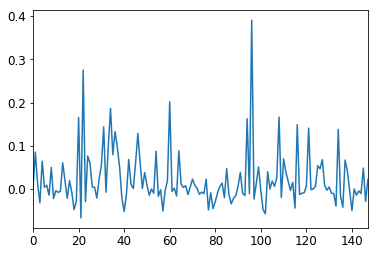

In [99]:
population = lrp_results.mean()
population.plot()

In [101]:
sorted_features = population.sort_values(ascending=False)
best_features = sorted_features[:6]

In [102]:
best_features.index

Int64Index([96, 22, 60, 34, 108, 20], dtype='int64')

In [103]:
# abs(lrp_results)[best_features.index].hist(figsize=(20,20))

In [104]:
raw_features.columns[best_features.index]

Index(['G_oc-temp_med-Parahip_TH_rh', 'G_oc-temp_med-Parahip_TH_lh',
       'S_oc-temp_med_and_Lingual_TH_lh', 'G_temp_sup-Plan_polar_TH_lh',
       'G_temp_sup-Plan_polar_TH_rh', 'G_oc-temp_lat-fusifor_TH_lh'],
      dtype='object')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147]), <a list of 148 Text xticklabel objects>)

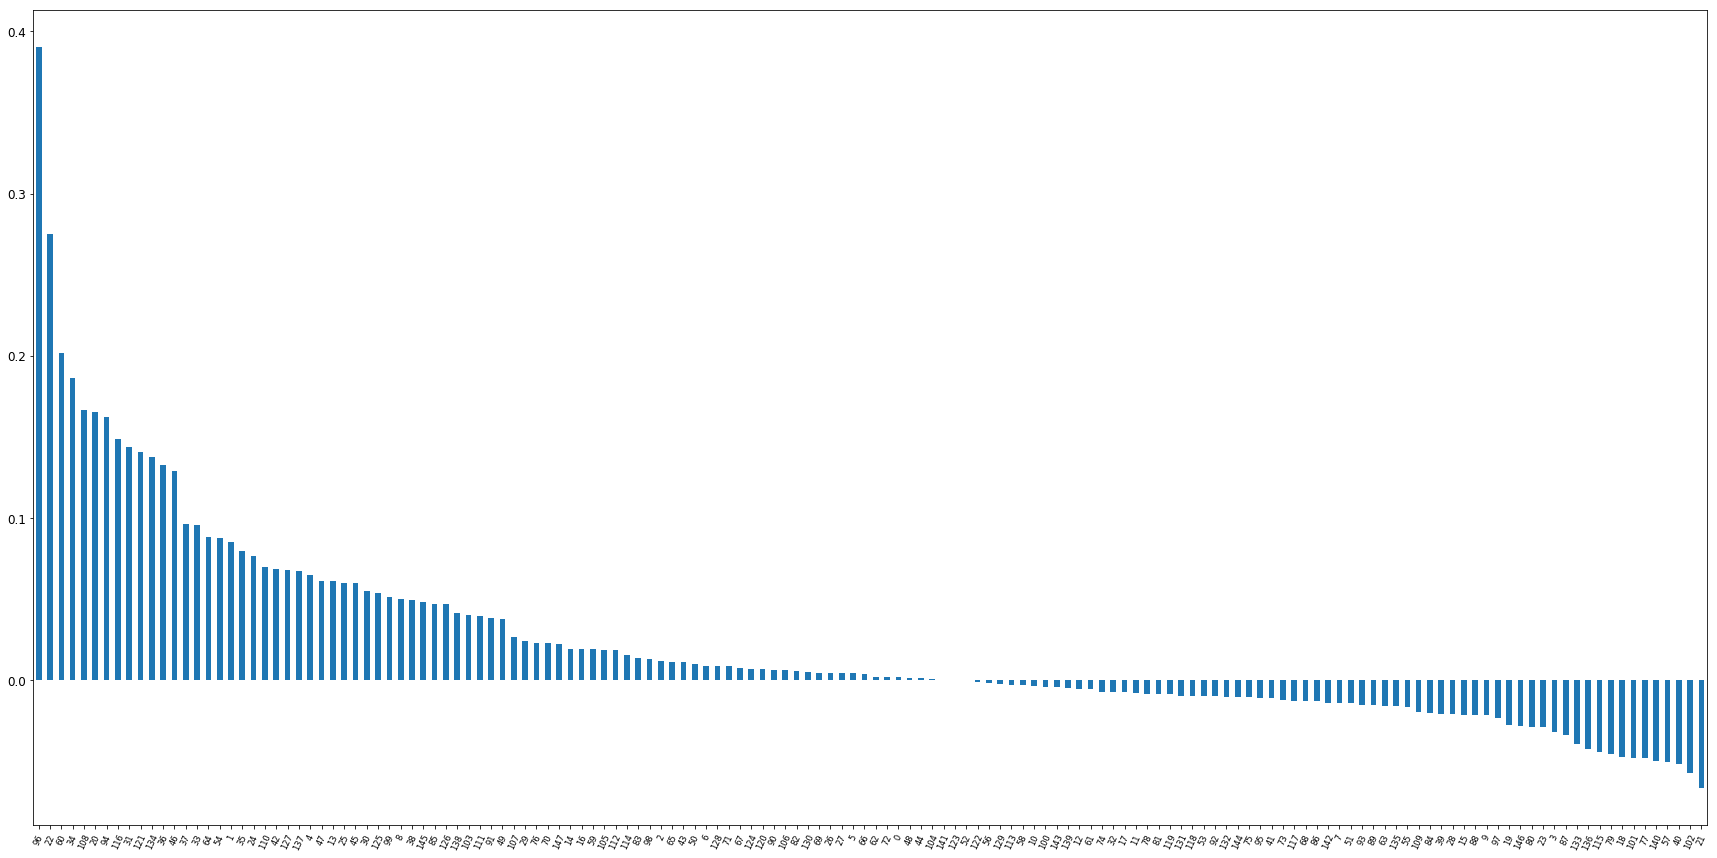

In [105]:
sorted_features.plot(kind="bar", figsize=[30,15])
plt.xticks(rotation=65, fontsize="small")

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(ALL_lrp)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [98]:
print("Variance: ", pca.explained_variance_ratio_)
# pca.components_

Variance:  [0.22982224 0.08046127]


In [82]:
X = pca.transform(ALL_lrp)
df = pd.DataFrame(X, columns=["PC1","PC2"])
_labels = np.array([np.argmax(x) for x in all_labels])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
PC1    74 non-null float64
PC2    74 non-null float64
dtypes: float64(2)
memory usage: 1.2 KB


Categories: [array(['AD', 'CN'], dtype=object)]


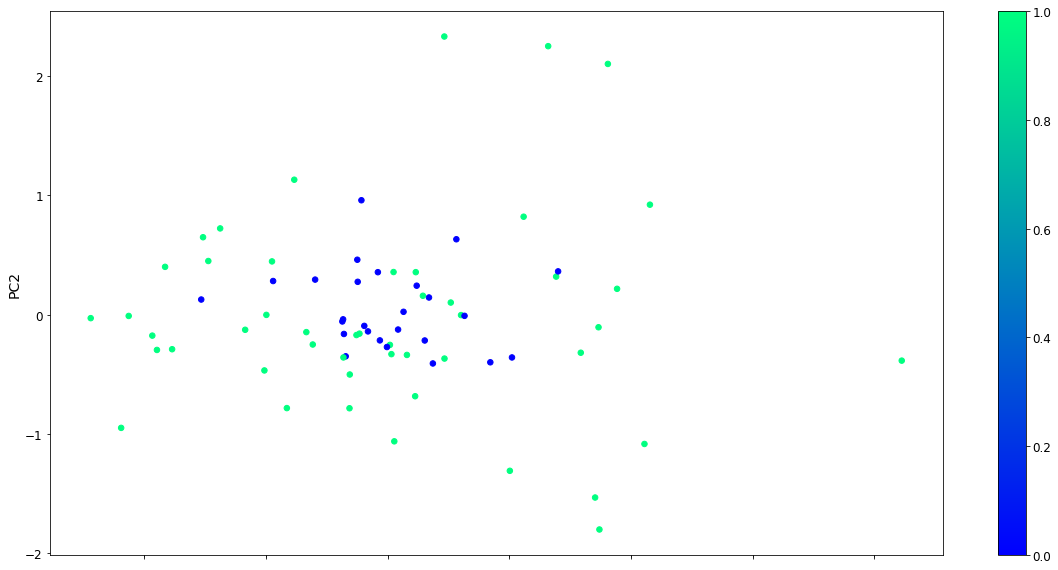

In [94]:
df.plot.scatter(x="PC1", y="PC2", s= 30, c=_labels, colormap='winter', figsize=(20,10))
# plt.legend(["AD", "CN"])
print("Categories:", hot_encoder.categories_)

In [68]:

df["Type"] = 11
df2 = pd.DataFrame(X, columns=["PC1","PC2"])

In [95]:
# # pd.concat([df,df2*500], axis=0)
# all_labels